In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import itertools

In [2]:
from pathlib import Path
Path("holonomic_data").mkdir(parents=True, exist_ok=True)
Path("nonhn_data").mkdir(parents=True, exist_ok=True)
Path("holo_wheel_data").mkdir(parents=True, exist_ok=True)
Path("nh_wheel_data").mkdir(parents=True, exist_ok=True)

In [3]:
class env:
    def __init__(self,obs_x,obs_y,X_triangle,xmin,xmax,ymin,ymax):
        self.obst_x = obs_x
        self.obst_y = obs_y
        self.xlim = (xmin,xmax)
        self.ylim = (ymin,ymax)
        self.X_triangle = X_triangle
        
    def area(self, x1, y1, x2, y2, x3, y3): # Calculating the area of a triangle
        return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                    + x3 * (y1 - y2)) / 2.0) 
    
    def isInside(self, x1, y1, x2, y2, x3, y3, x, y): # Checking if a point lies inside a triangle.

        A = self.area(x1, y1, x2, y2, x3, y3) 

        A1 = self.area(x, y, x2, y2, x3, y3) 
 
        A2 = self.area(x1, y1, x, y, x3, y3) 
 
        A3 = self.area(x1, y1, x2, y2, x, y) 

        if(A == A1 + A2 + A3): 
            return True
        else: 
            return False
        
    def obs_add(self,ox,oy):
        self.obst_x += ox
        self.obst_y += oy

    def inobstacle(self,x1,y1,x2,y2): #check if edge lies inside obstacle
        c=1 #assume no collision
        obs_num = len(self.obst_x)/4 
        for i in range(1,int(obs_num)+1): #Checking if the edge lies in one of the rectangles
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            for j in range(0,101):
                u=j/100.0
                x=x1*u+x2*(1-u)
                y=y1*u+y2*(1-u)
                if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                    c=0
                    break
            if c==0:
                break
                
        if c==1: # If a collision hasnt occured with a rectangle
            for i in range(2):
                x1t = self.X_triangle[3*i][0]
                y1t = self.X_triangle[3*i][1]
                x2t = self.X_triangle[3*i+1][0]
                y2t = self.X_triangle[3*i+1][1]
                x3t = self.X_triangle[3*i+2][0]
                y3t = self.X_triangle[3*i+2][1]
                for j in range(0,101):
                    u=j/100.0
                    x=x1*u+x2*(1-u)
                    y=y1*u+y2*(1-u)
                    if (self.isInside(x1t, y1t, x2t, y2t, x3t, y3t, x, y)): 
                        c=0
                        break
                if c == 0:
                    break
        return c

    def isfree(self): #check if new node lies inside obstacle
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        obs_num = len(self.obst_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,int(obs_num)+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                G.remove_node(n)
                return 0
                break
        for i in range(2): # For triangle
            x1 = self.X_triangle[3*i][0]
            y1 = self.X_triangle[3*i][1]
            x2 = self.X_triangle[3*i+1][0]
            y2 = self.X_triangle[3*i+1][1]
            x3 = self.X_triangle[3*i+2][0]
            y3 = self.X_triangle[3*i+2][1]
            if (self.isInside(x1, y1, x2, y2, x3, y3, x, y)): 
                G.remove_node(n)
                return 0
                break             
        return 1
                
    def ingoal(self):
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        tol = 5
        if (np.linalg.norm(np.array([x-xg,y-yg])**2)<tol):
            return 1
        else:
            return 0

#check for a specific node
    def isfree_xy(self,x,y): 
        obs_num = len(self.obst_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,obs_num+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                return 0
            break
        for i in range(2): # For triangle
            x1 = self.X_triangle[3*i][0]
            y1 = self.X_triangle[3*i][1]
            x2 = self.X_triangle[3*i+1][0]
            y2 = self.X_triangle[3*i+1][1]
            x3 = self.X_triangle[3*i+2][0]
            y3 = self.X_triangle[3*i+2][1]
            if (self.isInside(x1, y1, x2, y2, x3, y3, x, y)): 
                return 0
            break 

#Sensing
#Check for obstacles given the robot's current position and the sensor 
#Only hidden obstacles are checked, others are known a-priori

#     def sense (self,x,y,r):
#         obs_num = len(hvx)/4 #four vertices for each rectangular obstacle
#         for i in range(1,obs_num+1):
#             xomin=hvx[4*(i-1)]-r
#             xomax=hvx[4*(i-1)+2]+r
#             yomin=hvy[4*(i-1)]-r
#             yomax=hvy[4*(i-1)+1]+r
#             if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
# #if the robot is within the sensing range of the obstacle, add it to visibile list
#                 hx_i= [hvx[4*(i-1)],hvx[4*(i-1)],hvx[4*(i-1)+2],hvx[4*(i-1)+2]]
#                 hy_i= [hvy[4*(i-1)],hvy[4*(i-1)+1],hvy[4*(i-1)+1],hvy[4*(i-1)]]
#                 self.obs_add(hx_i,hy_i)
# #add point where new obstacle detected
#                 return 1

## Holonomic

In [4]:
class holonomic_RRT:
    def __init__(self,nstart):
        (x,y,theta0)=nstart
        self.x=[]
        self.y=[]
        self.theta=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        self.theta.append(theta0)
        #first node is the only node whose parent is itself
        self.parent.append(0)

    #get metric value (current metric is euclidean distance)
    def metric(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        x1=float(x1)
        y1=float(y1)
        x2=float(x2)
        y2=float(y2)
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric

    def holonomic_kinematics(xdot,ydot,thetadot):
        theta = thetadot*del_t
        w1 = theta
        w2 = theta + 2*np.pi/3
        w3 = theta + 4*np.pi/3
        controls = np.array([[xdot,ydot,thetadot]]).T
        kin_mat = 1/wrad*np.array([[-np.sin(w1),np.cos(w1),rbot],
                                   [-np.sin(w2),np.cos(w2),rbot],
                                   [-np.sin(w3),np.cos(w3),rbot]])
        ang_velos = np.dot(kin_mat,controls)
        wv1 = ang_velos[0][0]*rbot
        wv2 = ang_velos[1][0]*rbot
        wv3 = ang_velos[2][0]*rbot
        return wv1,wv2,wv3
        
        
    #expand a random point
    #calls subroutines to find nearest node and connect it
    def expand (self):
        #add random node
        thetadot = random.uniform(-thetadot_lim,thetadot_lim)
        xdot = random.uniform(vxmin,vxmax)
        ydot = random.uniform(vymin,vymax)
        x = xdot*del_t
        y = ydot*del_t
        theta = thetadot*del_t
#         x = random.uniform (E.xlim[0], E.xlim[1])
#         y = random.uniform (E.ylim[0], E.ylim[1])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y,theta)
        if E.isfree()!=0:
            #find nearest node
            nnear = self.near(n)
            #find new node based on step size
            self.step(nnear,n,theta)
            #connect the random node with its nearest node
            self.connect(nnear,n)

    def bias (self):
        #add random node
        n= self.number_of_nodes() #new node
        self.add_node(n,xg,yg) #test goal region
        #find nearest node
        nnear = self.near(n)
        #find new node based on step size
        self.step(nnear,n)
        #connect the random node with its nearest node
        self.connect(nnear,n)

    #nearest node
    def near(self,n):
        #find a near node
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if self.metric(i,n) < dmin:
                dmin=self.metric(i,n)
                nnear = i
        return nnear

#step size
    def step(self,nnear,nrand,theta):
        d = self.metric(nnear,nrand)
        if d>dmax:
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (xrand,yrand)= (self.x[nrand],self.y[nrand]) 
            (px,py)=(xrand-xnear,yrand-ynear)
            theta_des = math.atan2(py,px)
            (x,y)=(xnear+dmax*math.cos(theta_des),ynear+dmax*math.sin(theta_des))
            self.remove_node(nrand)
            self.add_node(nrand,x,y,theta) #this is a new node between rand and near

#connect two nodes (local planner)
    def connect(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        n= G.number_of_nodes()-1
        #subdivide path into 100 small segments and ensure each segment is collision free
        if E.inobstacle(x1,y1,x2,y2)==0:
            self.remove_node(n2)
        else:
            self.add_edge(n1,n2)


#add node
    def add_node(self,n,x,y,theta):
        self.x.insert(n, x)
        self.y.insert(n, y)
        self.theta.insert(n,theta)

#remove node
    def remove_node(self,n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)

#add edge
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

#remove node
    def remove_edge(self,n):
        self.parent.pop(n)
#clear
    def clear(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)
        
#number of nodes
    def number_of_nodes(self):
        return len(self.x)

#path to goal
    def path_to_goal(self):
        #find goal state
        for i in range (0,G.number_of_nodes()):
            (x,y)= (self.x[i],self.y[i])
            if (x>=xgmin) and (x<=xgmax) and (y>=ygmin) and (y<=ygmax):
                self.goalstate = i
                break
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
        #add start state
        self.path.append(0)

#     def prun(self):
#         #initial query nodes in the path
#         #we already know 0-1 is collision free
#         #start by checking 0-2
#         s=0
#         e=2
#         self.tpath=[]
#         self.tpath.append(self.path[s])
#         for e in range(len(self.path)-1):
#             (x1,y1)=(self.x[self.path[s]],self.y[self.path[s]])
#             (x2,y2)=(self.x[self.path[e]],self.y[self.path[e]])
#             if E.inobstacle(x1,y1,x2,y2)==0: #CC is detected
#                 c=0
#                 self.tpath.append(self.path[e-1])
#                 s=e-1
#         self.tpath.append(self.path[-1])

        
    #draw tree
    def showtree(self,k):
        node_num = 0
        for i in range (0,self.number_of_nodes()):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)
#             n = len(self.path)-1
#             if (node_num <= n-2):
#                 n1 = self.path[n-node_num]
#                 n2 = self.path[n-(node_num+1)]
#                 if (self.x[i]==self.x[n1] and self.y[i]==self.y[n1]):
# #                     print ("yay")
#                     plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],'ro-',lw=1,markersize=3)
#                     node_num+=1
            plt.title('Step: %d' %(i+1))
            name = 'holonomic_data/snap%s.png'%str(i)
            plt.savefig(name, dpi = 200)

    #draw path 
    def showpath(self,k):
        n = len(self.path)-1
        start = self.path[n]
        start_w1x = self.x[start]+rbot*np.cos(self.theta[start])
        start_w1y = self.y[start]+rbot*np.sin(self.theta[start])
        start_w2x = self.x[start]+rbot*np.cos(self.theta[start]+2*np.pi/3)
        start_w2y = self.y[start]+rbot*np.sin(self.theta[start]+2*np.pi/3)
        start_w3x = self.x[start]+rbot*np.cos(self.theta[start]+4*np.pi/3)
        start_w3y = self.y[start]+rbot*np.sin(self.theta[start]+4*np.pi/3)
        w1_pos.append((start_w1x,start_w1y))
        w2_pos.append((start_w2x,start_w2y))
        w3_pos.append((start_w3x,start_w3y))
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            x_diff = self.x[n2]-self.x[n1]
            y_diff = self.y[n2]-self.x[n1]
            theta_diff = self.theta[n2]-self.theta[n1]
            xdot = x_diff/del_t
            ydot = y_diff/del_t
            thetadot = theta_diff/del_t
#             vw1,vw2,vw3 = holonomic_kinematics(xdot,ydot,thetadot)
            w1_x = self.x[n2]+rbot*np.cos(self.theta[n2])
            w1_y = self.y[n2]+rbot*np.sin(self.theta[n2])
            w2_x = self.x[n2]+rbot*np.cos(self.theta[n2]+2*np.pi/3)
            w2_y = self.y[n2]+rbot*np.sin(self.theta[n2]+2*np.pi/3)
            w3_x = self.x[n2]+rbot*np.cos(self.theta[n2]+4*np.pi/3)
            w3_y = self.y[n2]+rbot*np.sin(self.theta[n2]+4*np.pi/3)
            centre_pos.append((self.x[n2],self.y[n2]))
            w1_pos.append((w1_x,w1_y))
            w2_pos.append((w2_x,w2_y))
            w3_pos.append((w3_x,w3_y))
            
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
            plt.title('Step: %d' %(self.number_of_nodes()))
            name = 'holonomic_data/snap%s.png'%str(i+self.number_of_nodes())
#             plt.show()
            plt.savefig(name, dpi = 200)
#             self.visualize_wheels(w1_pos,w2_pos,w3_pos,centre_pos)

In [5]:
def draw ():
    #draw boundary
    plt.plot([0,0,100,100,0],[0,100,100,0,0],'k',lw=0.5)

    #goal region
#     plt.plot([xgmin,xgmin,xgmax,xgmax,xgmin],[ygmin,ygmax,ygmax,ygmin,ygmin],'g',lw=2)
    plt.plot(xg,yg,'g*',markersize=20)

    num = len(E.obst_x)/4
    for i in range(1,int(num)+1): # Plotting rectangles
        plt.plot([v_origx[4*(i-1)],v_origx[4*(i-1)+1],v_origx[4*(i-1)+2],
        v_origx[4*(i-1)+3],v_origx[4*(i-1)]],[v_origy[4*(i-1)],v_origy[4*(i-1)+1],
        v_origy[4*(i-1)+2],v_origy[4*(i-1)+3],v_origy[4*(i-1)]],'k',lw=2)

#     pp
    plt.scatter(E.X_triangle[:, 0], E.X_triangle[:, 1])
    t1 = plt.Polygon(E.X_triangle[:3,:])
    plt.gca().add_patch(t1)
    t2 = plt.Polygon(E.X_triangle[3:6,:])
    plt.gca().add_patch(t2)
    G.showtree('0.15')
 
    #draw path
    G.showpath('ro-')
#     G.showtpath('g*-')
    
    #draw obstacles


    #draw  hidden obstacles (if they exist)
#     obs_num = len(hvx)/4
#     for i in range(1,int(obs_num)+1):
#         plt.plot([hvx[4*(i-1)],hvx[4*(i-1)+1],hvx[4*(i-1)+2],hvx[4*(i-1)+3],hvx[4*(i-1)]],[hvy[4*(i-1)],hvy[4*(i-1)+1],hvy[4*(i-1)+2],hvy[4*(i-1)+3],hvy[4*(i-1)]],'k--',lw=2)	

    plt.show()

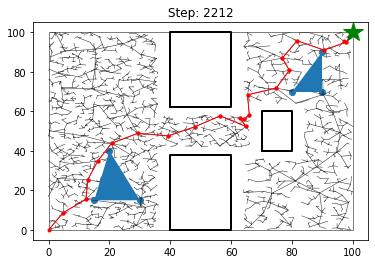

In [6]:
nmax = 5000

#goal region
xg=100
yg=100
epsilon=5
vxmin = vymin = 0
vxmax = xg
vymax= yg
thetadot_lim = 0.1
xgmin=xg-epsilon
xgmax=xg+epsilon
ygmin=yg-epsilon
ygmax=yg+epsilon
rbot = 2

#extend step size
dmax = 10
del_t = 1
#start the root of the tree
nstart =(0,0,0) 
n_rect_obst = 3
wrad = 1

#specify vertices for rectangular obstacles (each object has four vertices)
#obstacles known a priori
v_origx= [40,40,60,60,70,70,80,80,40,40,60,60]
v_origy= [62,100,100,62,40,60,60,40, 0,38,38, 0]

centre_pos = []
w1_pos = []
w2_pos = []
w3_pos = []

## Triangular obstacles
X_triangle = np.array([[15,15],[30,15], [20, 40],[80,70],[90,70],[90,90]])

# after padding obstacles ########## FILL IN TRIANGLE COZ IDK HOW TO DO
vx = [i for i in v_origx]
vy = [i for i in v_origy]
for i in range(n_rect_obst):
    vx[i*4]-=2*rbot
    vx[i*4+1] -=2*rbot
    vx[i*4+2] +=2*rbot
    vx[i*4+3] +=2*rbot
    vy[i*4]-=2*rbot
    vy[i*4+3] -=2*rbot
    vy[i*4+1] +=2*rbot
    vy[i*4+2] +=2*rbot

#create an RRT tree with a start node
G = holonomic_RRT(nstart)

#environment instance
E=env(vx,vy,X_triangle,0,100,0,100)

def main():
#     draw()
    for i in range(0,nmax):
#         if i%10!=0:
        G.expand()
        
        if E.ingoal()==1:
            break
    G.path_to_goal()
#     G.prun()
    
    draw()

    #display initial plan under limited sensing
#     G.path_to_goal()
#     G.prun()

    
# run main when RRT is called
if __name__ == '__main__':
    main()

In [7]:
def visualize_holo_wheels(w1_pos,w2_pos,w3_pos):
    print ("I'm here")
    w1_pos_x = [i[0] for i in w1_pos]
    w1_pos_y = [i[1] for i in w1_pos]

    w2_pos_x = [i[0] for i in w2_pos]
    w2_pos_y = [i[1] for i in w2_pos]

    w3_pos_x = [i[0] for i in w3_pos]
    w3_pos_y = [i[1] for i in w3_pos]
    for j in range(len(w1_pos)):
#         print ("Loopy")
#         print (j)
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        ax.plot([0,0,100,100,0],[0,100,100,0,0],'k',lw=0.5)
        ax.plot(100,100,'g*',markersize=20)
        num = len(E.obst_x)/4
        for i in range(1,int(num)+1): # Plotting rectangles
            ax.plot([v_origx[4*(i-1)],v_origx[4*(i-1)+1],v_origx[4*(i-1)+2],
            v_origx[4*(i-1)+3],v_origx[4*(i-1)]],[v_origy[4*(i-1)],v_origy[4*(i-1)+1],
            v_origy[4*(i-1)+2],v_origy[4*(i-1)+3],v_origy[4*(i-1)]],'k',lw=2)
        plt.scatter(E.X_triangle[:, 0], E.X_triangle[:, 1])
        t1 = plt.Polygon(E.X_triangle[:3,:])
        plt.gca().add_patch(t1)
        t2 = plt.Polygon(E.X_triangle[3:6,:])
        plt.gca().add_patch(t2)
    #         ax.plot(centre_pos_x,centre_pos_y,'k',markersize=3)
        ax.plot(w1_pos_x[:j],w1_pos_y[:j],'ro--')
        ax.plot(w2_pos_x[:j],w2_pos_y[:j],'go--')
        ax.plot(w3_pos_x[:j],w3_pos_y[:j],'ko--')
    #     ax.plot(w1_pos_x[-1],w1_pos_y[-1],'r*',markersize=3)
    #     ax.plot(w2_pos_x[-1],w2_pos_y[-1],'g*',markersize=3)
    #     ax.plot(w3_pos_x[-1],w3_pos_y[-1],'b*',markersize=3)
    #     plt.legend(["Centre","Wheel1","Wheel2","Wheel3"])
        name = 'holo_wheel_data/snap%s.png'%str(j)
        plt.savefig(name, dpi = 200)
#         plt.cla()
#         plt.close()

I'm here


<ipython-input-7-abcea17e6d2c>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


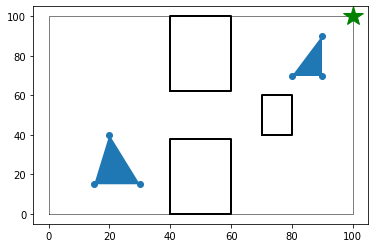

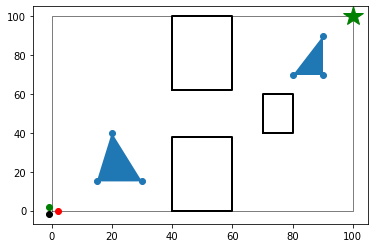

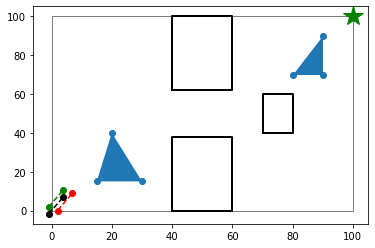

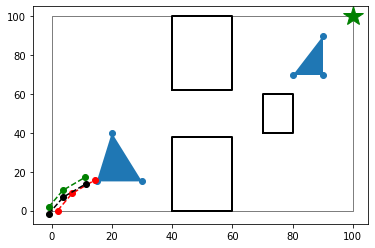

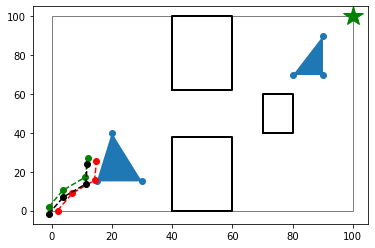

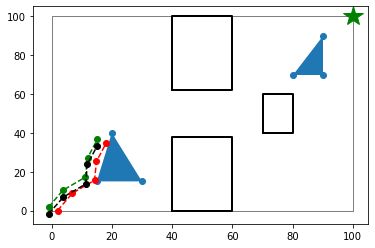

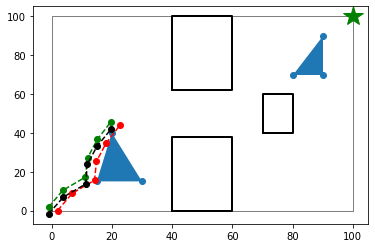

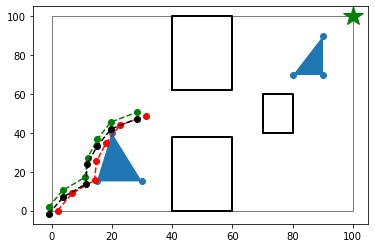

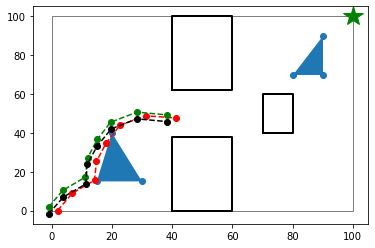

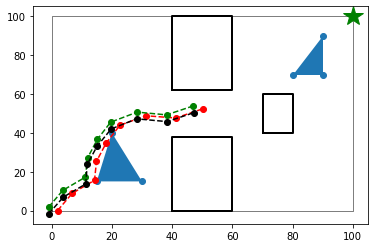

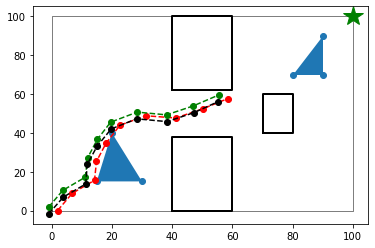

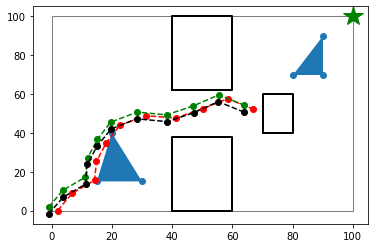

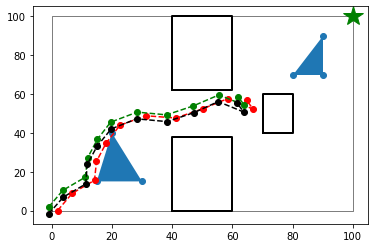

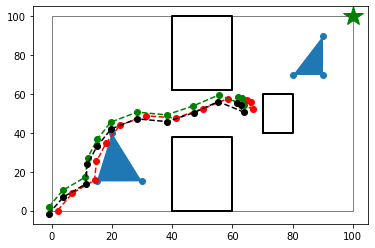

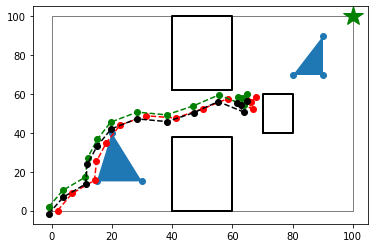

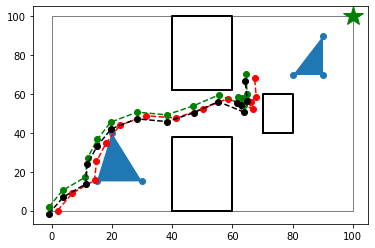

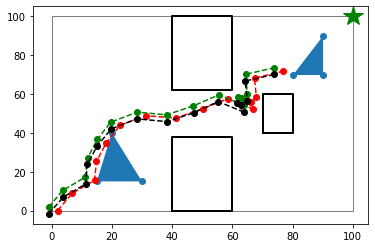

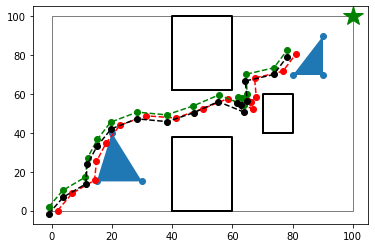

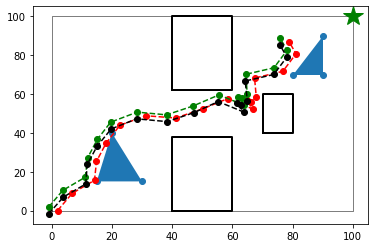

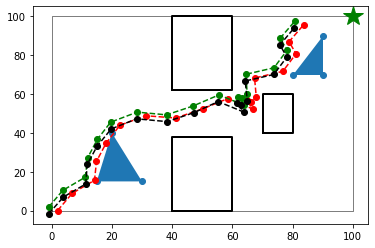

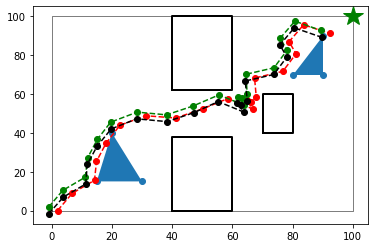

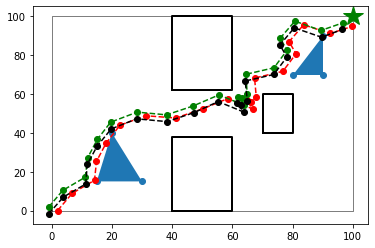

In [8]:
visualize_holo_wheels(w1_pos,w2_pos,w3_pos)

## Non-holonomic RRT

In [9]:
class nonhn_RRT:
    def __init__(self,nstart):
        (x,y,theta0)=nstart
        self.x=[]
        self.y=[]
        self.theta=[]
        self.vc = []
        self.wc = []
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        self.theta.append(theta0)
        self.vc.append(vinit)
        self.wc.append(winit)
        #first node is the only node whose parent is itself
        self.parent.append(0)

    #get metric value (current metric is euclidean distance)
    def metric(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        x1=float(x1)
        y1=float(y1)
        x2=float(x2)
        y2=float(y2)
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric

    def holonomic_kinematics(xdot,ydot,thetadot):
        theta = thetadot*del_t
        w1 = theta
        w2 = theta + 2*np.pi/3
        w3 = theta + 4*np.pi/3
        controls = np.array([[xdot,ydot,thetadot]]).T
        kin_mat = 1/wrad*np.array([[-np.sin(w1),np.cos(w1),rbot],
                                   [-np.sin(w2),np.cos(w2),rbot],
                                   [-np.sin(w3),np.cos(w3),rbot]])
        ang_velos = np.dot(kin_mat,controls)
        wv1 = ang_velos[0][0]*rbot
        wv2 = ang_velos[1][0]*rbot
        wv3 = ang_velos[2][0]*rbot
        return wv1,wv2,wv3
        
        
    #expand a random point
    #calls subroutines to find nearest node and connect it
    def expand (self):
        #add random node
        thetadot = random.uniform(-thetadot_lim,thetadot_lim)
        xdot = random.uniform(vxmin,vxmax)
        ydot = random.uniform(vymin,vymax)
        x = xdot*del_t
        y = ydot*del_t
        theta = thetadot*del_t
#         x = random.uniform (E.xlim[0], E.xlim[1])
#         y = random.uniform (E.ylim[0], E.ylim[1])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y,theta)
        if E.isfree()!=0:
            #find nearest node
            nnear = self.near(n)
            #find new node based on step size
            self.step(nnear,n,theta,vbest,wbest)
            #connect the random node with its nearest node
            self.connect(nnear,n)
            
    def expand_nh(self):
        #add random node
        x = random.uniform (E.xlim[0], E.xlim[1])
        y = random.uniform (E.ylim[0], E.ylim[1])
        theta = random.uniform(-math.pi, math.pi)
#         theta = random.choice([-math.pi/4, 0, math.pi/4])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y,theta,0,0)
        nnear = self.near(n) # Finding the nearest node to the randomly sampled node
        xfinal, yfinal, thetafinal, vbest, wbest = self.nonholonomic_drive(nnear,n)
        if E.xlim[0] <= xfinal <=  E.xlim[1] and E.ylim[0] <= yfinal <= E.ylim[1]:
            self.remove_node(n)
            self.add_node(n,xfinal,yfinal,thetafinal,vbest,wbest)
            if E.isfree()!=0:
                #find new node based on step size
                self.step(nnear,n,theta,vbest,wbest)
                #connect the random node with its nearest node
                self.connect(nnear,n)
        else:
            self.remove_node(n)
    
    def nonholonomic_drive(self,nnear,n):
        x0 = self.x[nnear]
        y0 = self.y[nnear]
        theta0 = self.theta[nnear]
        
        xgoal = self.x[n]
        ygoal = self.y[n]
        thetagoal = self.theta[n]
        
        v, w = [0.5, 6], [-math.pi/10, 0, math.pi/10]
        controls = list(itertools.product(v, w))
        
        max_dist = np.inf
        xfinal = 0
        yfinal = 0
        thetafinal = 0
        vbest = 0
        wbest = 0
        for i in controls:
            vtemp, wtemp = i[0], i[1]
            xnew = x0 + vtemp*del_t*math.cos(theta0 + wtemp*del_t)
            ynew = y0 + vtemp*del_t*math.sin(theta0 + wtemp*del_t)
             
            dist_from_goal = np.linalg.norm(np.array([xgoal,ygoal])-np.array([xnew,ynew]))
            
            if dist_from_goal < max_dist:
#                 print(dist_from_goal)
                xfinal = xnew
                yfinal = ynew
                thetafinal = (theta0 + wtemp*del_t)
                vbest = vtemp
                wbest = wtemp
                max_dist = dist_from_goal
                
        return xfinal, yfinal, thetafinal, vbest, wbest
        
    def bias (self):
        #add random node
        n= self.number_of_nodes() #new node
        self.add_node(n,xg,yg) #test goal region
        #find nearest node
        nnear = self.near(n)
        #find new node based on step size
        self.step(nnear,n)
        #connect the random node with its nearest node
        self.connect(nnear,n)

    #nearest node
    def near(self,n):
        #find a near node
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if self.metric(i,n) < dmin:
                dmin=self.metric(i,n)
                nnear = i
        return nnear

#step size
    def step(self,nnear,nrand,theta,vbest,wbest):
        d = self.metric(nnear,nrand)
#         print(d)
        if d>dmax:
            print("check")
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (xrand,yrand)= (self.x[nrand],self.y[nrand]) 
            (px,py)=(xrand-xnear,yrand-ynear)
            theta_des = self.theta[nnear] + wbest*del_t
            (x,y)=(xnear+vbest*del_t*math.cos(theta_des),ynear+vbest*del_t*math.sin(theta_des))
            self.remove_node(nrand)
            self.add_node(nrand,x,y,theta,vbest,wbest) #this is a new node between rand and near

#connect two nodes (local planner)
    def connect(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        n= G.number_of_nodes()-1
        #subdivide path into 100 small segments and ensure each segment is collision free
        if E.inobstacle(x1,y1,x2,y2)==0:
            self.remove_node(n2)
        else:
            self.add_edge(n1,n2)


#add node
    def add_node(self,n,x,y,theta,v,w):
        self.x.insert(n, x)
        self.y.insert(n, y)
        self.theta.insert(n,theta)
        self.vc.insert(n,v)
        self.wc.insert(n,w)

#remove node
    def remove_node(self,n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)
        self.vc.pop(n)
        self.wc.pop(n)

#add edge
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

#remove node
    def remove_edge(self,n):
        self.parent.pop(n)
#clear
    def clear(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)
        
#number of nodes
    def number_of_nodes(self):
        return len(self.x)

#path to goal
    def path_to_goal(self):
        #find goal state
        for i in range (0,G.number_of_nodes()):
            (x,y)= (self.x[i],self.y[i])
            if (x>=xgmin) and (x<=xgmax) and (y>=ygmin) and (y<=ygmax):
                self.goalstate = i
                break
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
        #add start state
        self.path.append(0)

#     def prun(self):
#         #initial query nodes in the path
#         #we already know 0-1 is collision free
#         #start by checking 0-2
#         s=0
#         e=2
#         self.tpath=[]
#         self.tpath.append(self.path[s])
#         for e in range(len(self.path)-1):
#             (x1,y1)=(self.x[self.path[s]],self.y[self.path[s]])
#             (x2,y2)=(self.x[self.path[e]],self.y[self.path[e]])
#             if E.inobstacle(x1,y1,x2,y2)==0: #CC is detected
#                 c=0
#                 self.tpath.append(self.path[e-1])
#                 s=e-1
#         self.tpath.append(self.path[-1])

        
    #draw tree
    def showtree(self,k):
        node_num = 0
        for i in range (0,self.number_of_nodes()):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)
#             n = len(self.path)-1
#             if (node_num <= n-2):
#                 n1 = self.path[n-node_num]
#                 n2 = self.path[n-(node_num+1)]
#                 if (self.x[i]==self.x[n1] and self.y[i]==self.y[n1]):
# #                     print ("yay")
#                     plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],'ro-',lw=1,markersize=3)
#                     node_num+=1

#             plt.title('Step: %d' %(i+1))
#             name = 'data/snap%s.png'%str(i)
#             plt.savefig(name, dpi = 200)

    #draw path 
    def showpath(self,k):
        n = len(self.path)-1
#         start = self.path[n]
#         start_w1x = self.x[start]+rbot*np.cos(self.theta[start])
#         start_w1y = self.y[start]+rbot*np.sin(self.theta[start])
#         start_w2x = self.x[start]+rbot*np.cos(self.theta[start]+2*np.pi/3)
#         start_w2y = self.y[start]+rbot*np.sin(self.theta[start]+2*np.pi/3)
#         start_w3x = self.x[start]+rbot*np.cos(self.theta[start]+4*np.pi/3)
#         start_w3y = self.y[start]+rbot*np.sin(self.theta[start]+4*np.pi/3)
#         w1_pos.append((start_w1x,start_w1y))
#         w2_pos.append((start_w2x,start_w2y))
#         w3_pos.append((start_w3x,start_w3y))
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            centre_v.append((self.vc[n2]))
            w_list.append((self.wc[n2]))
#             x_diff = self.x[n2]-self.x[n1]
#             y_diff = self.y[n2]-self.x[n1]
#             theta_diff = self.theta[n2]-self.theta[n1]
#             xdot = x_diff/del_t
#             ydot = y_diff/del_t
#             thetadot = theta_diff/del_t
# #             vw1,vw2,vw3 = holonomic_kinematics(xdot,ydot,thetadot)
#             w1_x = self.x[n2]+rbot*np.cos(self.theta[n2])
#             w1_y = self.y[n2]+rbot*np.sin(self.theta[n2])
#             w2_x = self.x[n2]+rbot*np.cos(self.theta[n2]+2*np.pi/3)
#             w2_y = self.y[n2]+rbot*np.sin(self.theta[n2]+2*np.pi/3)
#             w3_x = self.x[n2]+rbot*np.cos(self.theta[n2]+4*np.pi/3)
#             w3_y = self.y[n2]+rbot*np.sin(self.theta[n2]+4*np.pi/3)
#             centre_pos.append((self.x[n2],self.y[n2]))
#             w1_pos.append((w1_x,w1_y))
#             w2_pos.append((w2_x,w2_y))
#             w3_pos.append((w3_x,w3_y))
            
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
#             plt.title('Step: %d' %(self.number_of_nodes()))
#             name = 'data/snap%s.png'%str(i+self.number_of_nodes())
#             plt.savefig(name, dpi = 200)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

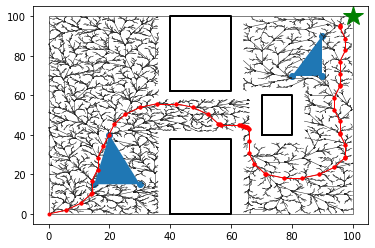

In [10]:
nmax = 50000

#goal region
xg=100
yg=100
epsilon=5
# vxmin = vymin = 0
# vxmax = xg
# vymax= yg
# thetadot_lim = 0.1
vinit = 5
winit = 0.1
xgmin=xg-epsilon
xgmax=xg+epsilon
ygmin=yg-epsilon
ygmax=yg+epsilon
rbot = 2

#extend step size
dmax = 10
del_t = 1
#start the root of the tree
nstart =(0,0,0) 
n_rect_obst = 3
wrad = 1

#specify vertices for rectangular obstacles (each object has four vertices)
#obstacles known a priori
v_origx= [40,40,60,60,70,70,80,80,40,40,60,60]
v_origy= [62,100,100,62,40,60,60,40, 0,38,38, 0]

centre_v = []
lw_v = []
w_list = []
rw_v = []

## Triangular obstacles
X_triangle = np.array([[15,15],[30,15], [20, 40],[80,70],[90,70],[90,90]])

# after padding obstacles ########## FILL IN TRIANGLE COZ IDK HOW TO DO
vx = [i for i in v_origx]
vy = [i for i in v_origy]
for i in range(n_rect_obst):
    vx[i*4]-=2*rbot
    vx[i*4+1] -=2*rbot
    vx[i*4+2] +=2*rbot
    vx[i*4+3] +=2*rbot
    vy[i*4]-=2*rbot
    vy[i*4+3] -=2*rbot
    vy[i*4+1] +=2*rbot
    vy[i*4+2] +=2*rbot

#create an RRT tree with a start node
G = nonhn_RRT(nstart)

#environment instance
E=env(vx,vy,X_triangle,0,100,0,100)

def main():
#     draw()
    for i in range(0,nmax):
        if i%10 ==0:
            print(i)
        G.expand_nh()
        
        if E.ingoal()==1:
            break
    G.path_to_goal()
    
    draw()

    #display initial plan under limited sensing
#     G.path_to_goal()
#     G.prun()

    
# run main when RRT is called
if __name__ == '__main__':
    main()

In [17]:
b = 1
lw_x = []
lw_y = []
rw_x = []
rw_y = []
centre_x = []
centre_y = []
theta_list = []
lw_x.append(nstart[0])
rw_x.append(nstart[0])
lw_y.append(nstart[1]+b)
rw_y.append(nstart[1]-b)
centre_x.append(nstart[0])
centre_y.append(nstart[1])
theta_list.append(nstart[2])
lw_v = []
rw_v = []

def visualize_nh_wheels(vc,wc):
    for i in range(len(wc)):
#         if (wc[i]<0):
#             lw_v.append(vc[i] +b*wc[i])
#             rw_v.append(vc[i]-b*wc[i])
#         else:
        lw_v.append(vc[i]-b*wc[i])
        rw_v.append(vc[i]+b*wc[i])

    for i in range(len(lw_v)):
        theta_cur = theta_list[-1]+wc[i]*del_t
#         lw_x_cur = lw_x[-1]+lw_v[i]*del_t*np.cos(theta_cur)
#         lw_y_cur = lw_y[-1]+lw_v[i]*del_t*np.sin(theta_cur)
#         rw_x_cur = rw_x[-1]+rw_v[i]*del_t*np.cos(theta_cur)
#         rw_y_cur = rw_y[-1]+rw_v[i]*del_t*np.sin(theta_cur) 
        centre_x_cur = centre_x[-1]+vc[i]*del_t*np.cos(theta_cur)
        centre_y_cur = centre_y[-1]+vc[i]*del_t*np.sin(theta_cur)
        lw_x_cur = centre_x_cur - b*np.sin(theta_cur)
        lw_y_cur = centre_y_cur + b**np.cos(theta_cur)
        rw_x_cur = centre_x_cur + b*np.sin(theta_cur)
        rw_y_cur = centre_y_cur - b*np.cos(theta_cur) 
        
        print (math.sqrt((rw_x_cur-lw_x_cur)**2+(rw_y_cur-lw_y_cur)**2))
        theta_list.append(theta_cur)
        lw_x.append(lw_x_cur)
        rw_x.append(rw_x_cur)
        lw_y.append(lw_y_cur)
        rw_y.append(rw_y_cur)
        centre_x.append(centre_x_cur)
        centre_y.append(centre_y_cur)
        
    for j in range(len(lw_v)):
#         print ("Loopy")
#         print (j)
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        ax.plot([0,0,100,100,0],[0,100,100,0,0],'k',lw=0.5)
        ax.plot(100,100,'g*',markersize=20)
        num = len(E.obst_x)/4
        for i in range(1,int(num)+1): # Plotting rectangles
            ax.plot([v_origx[4*(i-1)],v_origx[4*(i-1)+1],v_origx[4*(i-1)+2],
            v_origx[4*(i-1)+3],v_origx[4*(i-1)]],[v_origy[4*(i-1)],v_origy[4*(i-1)+1],
            v_origy[4*(i-1)+2],v_origy[4*(i-1)+3],v_origy[4*(i-1)]],'k',lw=2)
        plt.scatter(E.X_triangle[:, 0], E.X_triangle[:, 1])
        t1 = plt.Polygon(E.X_triangle[:3,:])
        plt.gca().add_patch(t1)
        t2 = plt.Polygon(E.X_triangle[3:6,:])
        plt.gca().add_patch(t2)
    #         ax.plot(centre_pos_x,centre_pos_y,'k',markersize=3)
        ax.plot(lw_x[:j],lw_y[:j],'r--')
        ax.plot(rw_x[:j],rw_y[:j],'b--')
        ax.plot(centre_x[:j],centre_y[:j],'k-')
    #     ax.plot(w2_pos_x[-1],w2_pos_y[-1],'g*',markersize=3)
    #     ax.plot(w3_pos_x[-1],w3_pos_y[-1],'b*',markersize=3)
    #     plt.legend(["Centre","Wheel1","Wheel2","Wheel3"])
        name = 'nh_wheel_data/snap%s.png'%str(j)
        plt.savefig(name, dpi = 200)
    
    
    
    
    

2.0466039042833586
2.1574309947684247
2.266957431481097
2.3090169943749483
2.23606797749979
2.309016994374947
2.23606797749979
2.3090169943749492
2.3090169943749492
2.3090169943749492
2.2669574314810923
2.157430994768427
2.04660390428336
2.0
2.04660390428336
2.1574309947684234
2.266957431481097
2.1574309947684234
2.04660390428336
2.0
2.04660390428336
2.1574309947684234
2.0466039042833577
2.157430994768427
2.046603904283356
2.157430994768431
2.2669574314810874
2.3090169943749492
2.23606797749979
2.23606797749979
2.309016994374947
2.2669574314810896
2.157430994768428
2.046603904283356
2.0
2.046603904283356
2.157430994768428
2.2669574314810896
2.309016994374947
2.23606797749979
2.023732072882308
2.23606797749979
2.23606797749979
2.023732072882308
2.23606797749979
2.3090169943749452
2.23606797749979
2.23606797749979
2.23606797749979
2.3090169943749452
2.23606797749979
2.0237320728823103
2.23606797749979
2.3090169943749452


<ipython-input-17-1d39f361b144>:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


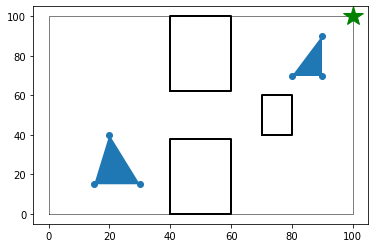

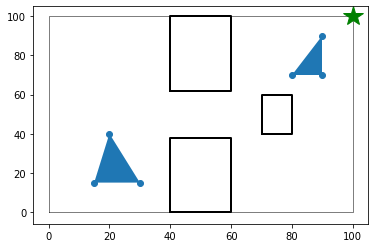

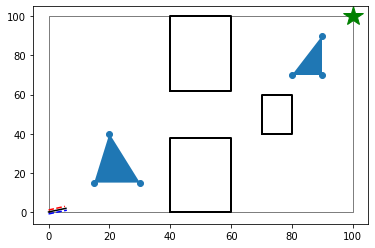

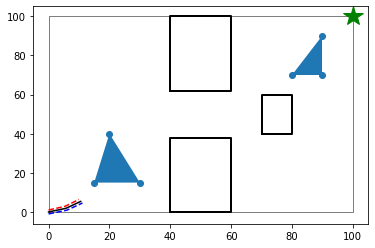

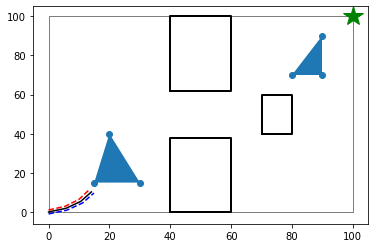

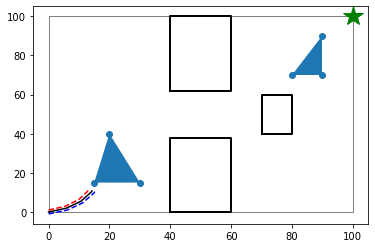

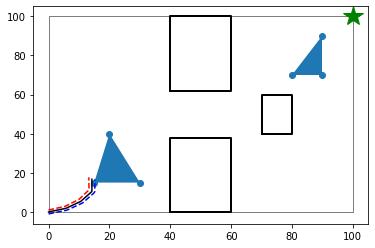

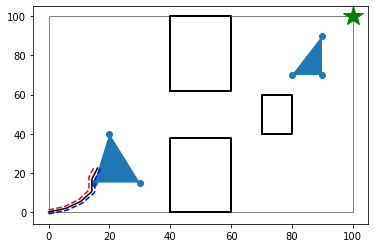

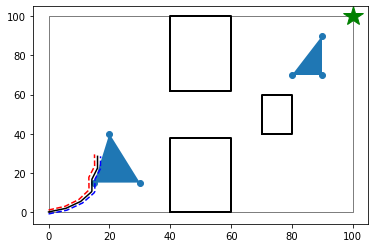

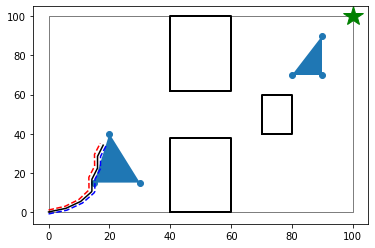

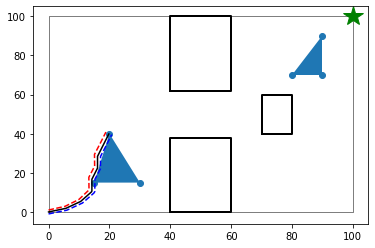

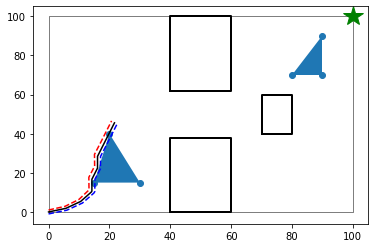

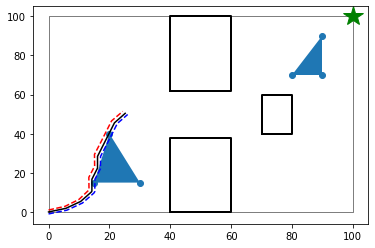

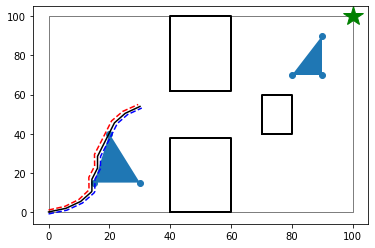

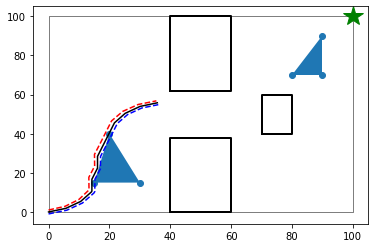

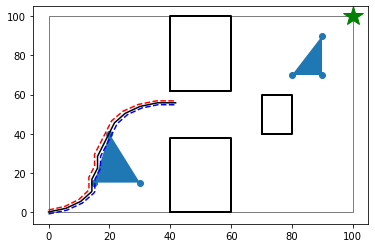

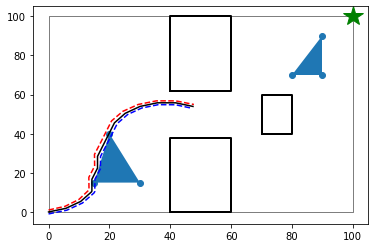

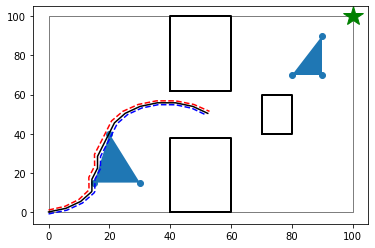

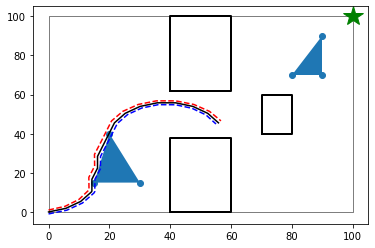

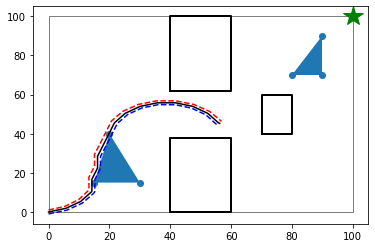

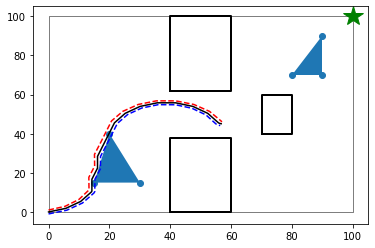

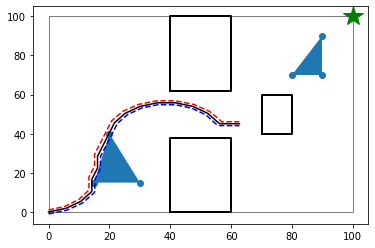

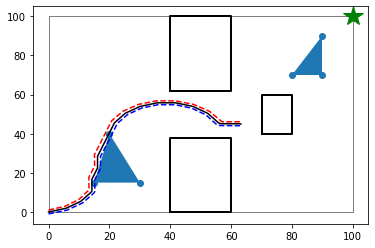

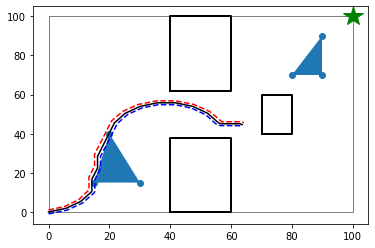

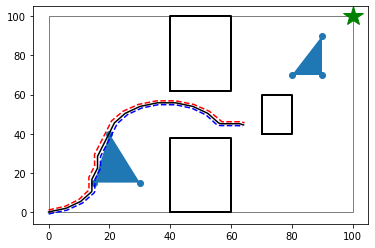

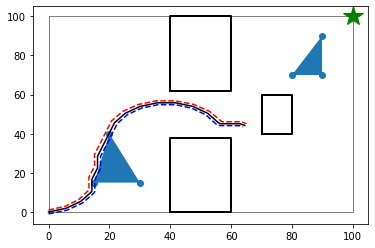

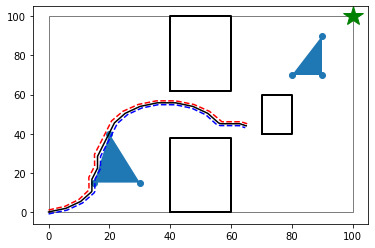

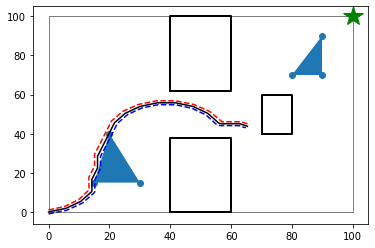

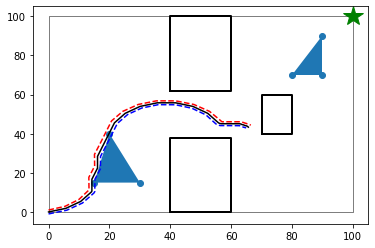

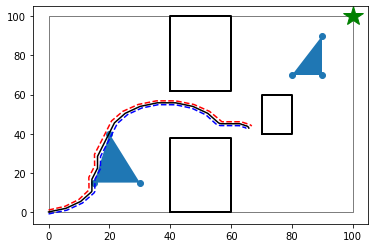

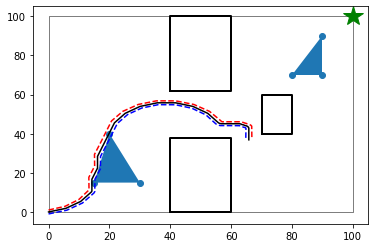

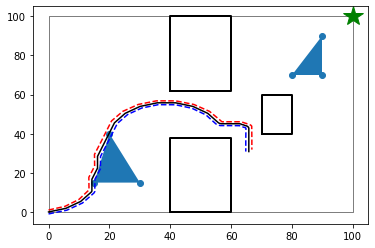

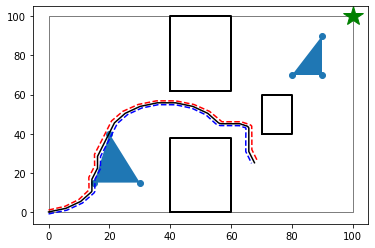

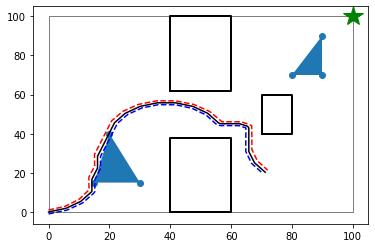

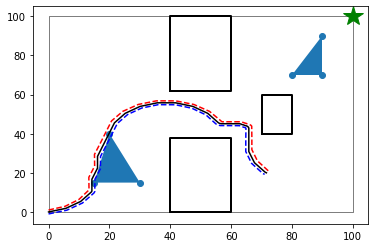

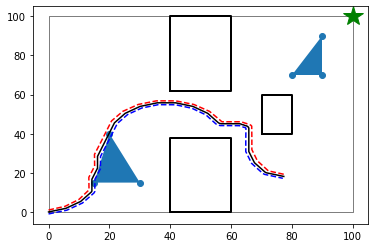

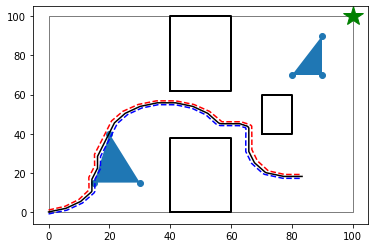

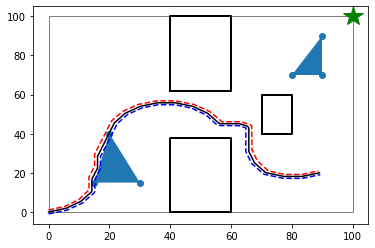

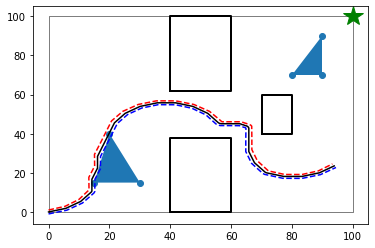

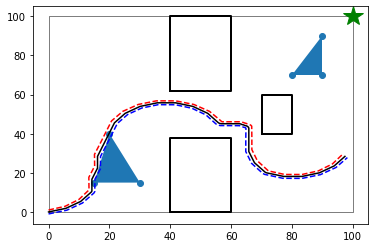

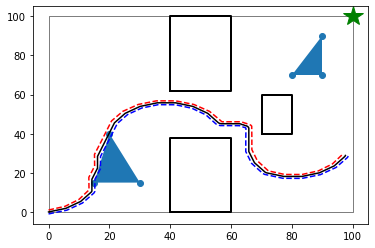

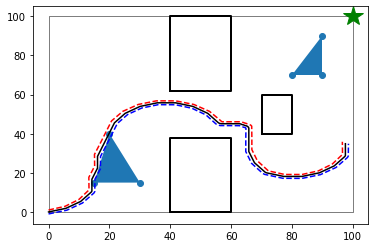

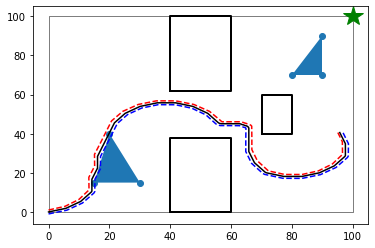

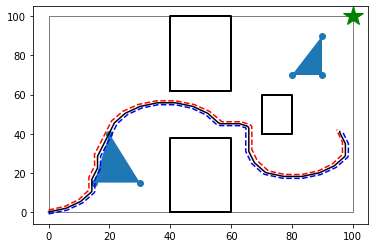

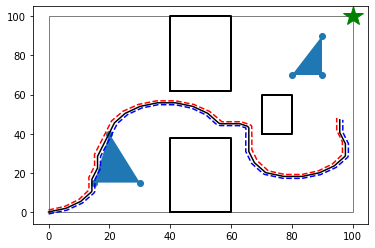

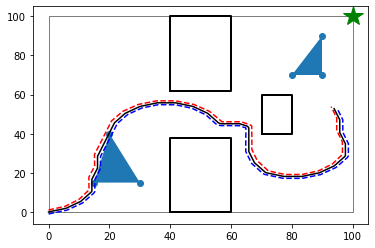

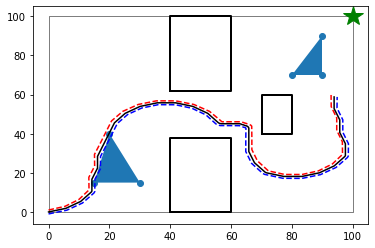

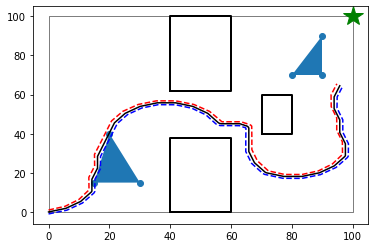

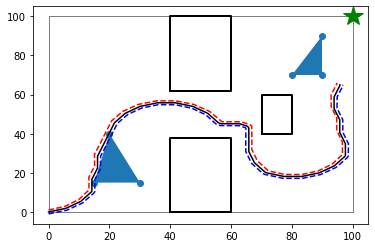

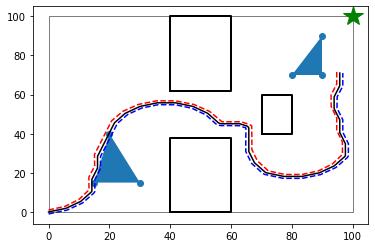

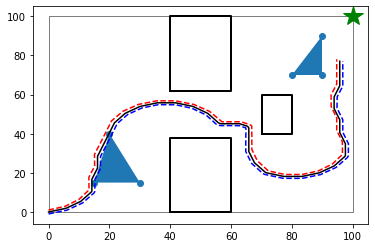

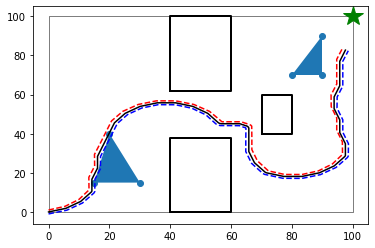

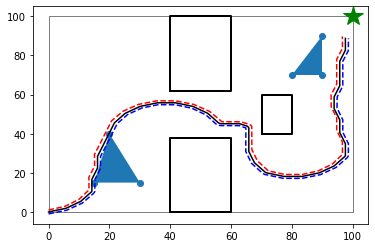

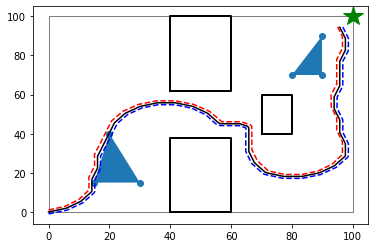

In [18]:
visualize_nh_wheels(centre_v,w_list)